In [14]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [15]:
# 1. 데이터 불러오기 
df = pd.read_csv('https://bit.ly/fc-ml-titanic')

In [16]:
# 2. 결측치 처리 

# KNNImputer 정의 (이웃 수는 보통 3~5 정도가 적당)
imputer = KNNImputer(n_neighbors=5)

# 결측치가 있는 컬럼만 선택 (Age, Fare, Embarked, Cabin 등)
cols_to_impute = ['Age','Fare']  # 숫자형만 먼저 KNN으로 처리하는 게 안정적

df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

# Embarked: 최빈값 대체 
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0]) 

# Cabin: 결측 여부만 변수화 
df['CabinKnown'] = df['Cabin'].notnull().astype(int)

In [17]:
# 3. 범주형 처리 
def convert_sex(x): 
    return 1 if x == 'male' else 0 
df['Sex'] = df['Sex'].apply(convert_sex) 
df = pd.get_dummies(df, columns=['Embarked'])

In [18]:
# 4. Feature / Label 정의 
# 
feature = ['Pclass','Sex','Age','Fare','Embarked_C','Embarked_Q','Embarked_S'] 
label = ['Survived'] 
x_train, x_valid, y_train, y_valid = train_test_split( df[feature], df[label], test_size=0.2, shuffle=True, random_state=42 )

In [19]:
# 5. 기본 파이프라인 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier 

# RandomForest 튜닝 
param_grid_rf = { 'n_estimators': [50,100,200], 'max_depth': [5,10,15,None] } 
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy') 
grid_rf.fit(x_train, y_train) 

# GradientBoosting 튜닝 
param_grid_gb = { 'n_estimators': [50,100,200], 'learning_rate': [0.05,0.1,0.2] } 
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='accuracy') 
grid_gb.fit(x_train, y_train) 

# 최적 모델들로 VotingClassifier 구성 
voting_clf = VotingClassifier( estimators=[('rf', grid_rf.best_estimator_), ('gb', grid_gb.best_estimator_), ('lr', LogisticRegression(max_iter=1000, random_state=42))], voting='soft' )
pipeline2 = Pipeline([ ('scaler', StandardScaler()), ('clf', voting_clf) ])

c:\Users\Creation23\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Creation23\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Creation23\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Creation23\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.

In [20]:
# RandomizedSearchCV 실행 
from sklearn.model_selection import GridSearchCV

# VotingClassifier가 인식하는 파라미터만 지정
param_grid = {
    'clf__voting': ['hard', 'soft'],                 # 투표 방식
    'clf__weights': [(1,1,1), (2,1,1), (1,2,1)]      # 각 모델 가중치
}

grid_search = GridSearchCV(
    estimator=pipeline2,      # pipeline2 안에 VotingClassifier가 들어 있음
    param_grid=param_grid,    # VotingClassifier 파라미터만 탐색
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Best Parameters: {'clf__voting': 'soft', 'clf__weights': (2, 1, 1)}
Best CV Accuracy: 0.8286319314488327


c:\Users\Creation23\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Creation23\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [21]:
# 7. 최적 모델로 평가 
best_model = grid_search.best_estimator_ 
y_pred = best_model.predict(x_valid) 
y_proba = best_model.predict_proba(x_valid)[:,1]
y_pred = (y_proba >= 0.4).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_valid, y_pred)) 
print("Accuracy:", accuracy_score(y_valid, y_pred)) 
print("Report:\n", classification_report(y_valid, y_pred))

Confusion Matrix:
 [[90 15]
 [15 59]]
Accuracy: 0.8324022346368715
Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       105
           1       0.80      0.80      0.80        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



In [27]:
feature = ['Pclass','Sex','Age','Fare','Embarked_C','Embarked_Q','Embarked_S']

# 테스트 데이터 불러오기
test_data = pd.read_csv("test.csv")
test = test_data.drop(['PassengerId','Name','Ticket','Cabin'], axis='columns')

# Embarked 원-핫 인코딩
test = pd.get_dummies(test, columns=['Embarked'], prefix='Embarked')

# 누락된 컬럼 채우기
for col in ['Embarked_C','Embarked_Q','Embarked_S']:
    if col not in test.columns:
        test[col] = 0

# Sex 변환
test['Sex'] = test['Sex'].apply(lambda x: 1 if x=='male' else 0)

# 👉 여기서 feature만 선택
test = test[feature]

# 결측치 처리
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
test = imputer.fit_transform(test)

# DataFrame으로 다시 변환 (이제 열 개수 = feature 개수)
test = pd.DataFrame(test, columns=feature)

# 예측
predictions = best_model.predict(test).astype(int)

# 제출 파일 생성
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': predictions
})
submission.to_csv("submission_tunning.csv", index=False)


C:\Users\Creation23\AppData\Local\Temp\ipykernel_3172\501685114.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=labels, y=count_data.values, palette="Set2") # 막대 위에 수치와 비율 표시


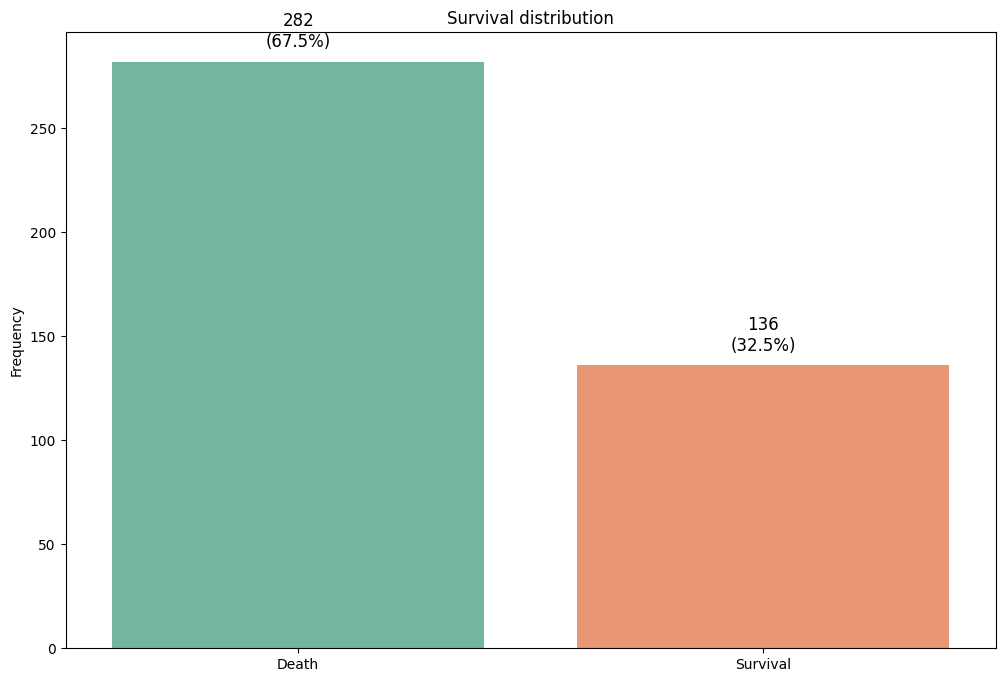

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
graph_data = pd.read_csv('submission_tunning.csv')
# Survived 값별로 개수 세기 
count_data = graph_data['Survived'].value_counts().sort_index() 
labels = ['Death', 'Survival'] 
total = count_data.sum() 
plt.figure(figsize=(12,8)) 
ax = sns.barplot(x=labels, y=count_data.values, palette="Set2") # 막대 위에 수치와 비율 표시 
for i, v in enumerate(count_data.values): 
    ax.text(i, v + 5, f"{v}\n({v/total*100:.1f}%)", 
            ha='center', va='bottom', fontsize=12) 
plt.ylabel('Frequency') 
plt.title('Survival distribution') 
plt.show()